In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam

import time

In [3]:
################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 6 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(201, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [4]:
PATH = 'fourier_burgers_dt0.002_Modes128'

model = torch.load(PATH)

# Visualization

In [554]:
############## MODULES IMPORTATION ###############
import numpy as np
from scipy.integrate import odeint


############## SET-UP THE PROBLEM ###############

mu = 1
nu = 1/1000 #kinematic viscosity coefficient
    
#Spatial mesh
L_x = 1 #Range of the domain according to x [m]
dx = 1/1024 #Infinitesimal distance
N_x = int(L_x/dx) #Points number of the spatial mesh
X = np.linspace(0,L_x,1024) #Spatial array

#Temporal mesh
L_t = 1 #Duration of simulation [s]
dt = 0.02  #Infinitesimal time
N_t = int(L_t/dt) #Points number of the temporal mesh
T = np.linspace(0,L_t,N_t) #Temporal array

#Wave number discretization
k = 2*np.pi*np.fft.fftfreq(N_x, d = 1/1024)


#Def of the initial condition    
u0 = np.sin(2*np.pi*(X))#*np.cos(2*np.pi*(X)) #Single space variable fonction that represent the wave form at t = 0
#viz_tools.plot_a_frame_1D(X,u0,0,L_x,0,1.2,'Initial condition')

#u0 = init_data

############## EQUATION SOLVING ###############

#Definition of ODE system (PDE ---(FFT)---> ODE system)
def burg_system(u,t,k,mu,nu):
    #Spatial derivative in the Fourier domain
    u_hat = np.fft.fft(u)
    u_hat_x = 1j*k*u_hat
    u_hat_xx = -k**2*u_hat
    
    #Switching in the spatial domain
    u_x = np.fft.ifft(u_hat_x)
    u_xx = np.fft.ifft(u_hat_xx)
    
    #ODE resolution
    u_t = -mu*u*u_x + nu*u_xx
    return u_t.real
    

#PDE resolution (ODE system resolution)
U = odeint(burg_system, u0, T, args=(k,mu,nu,), mxstep=5000).T

In [562]:
U.shape

(1024, 50)

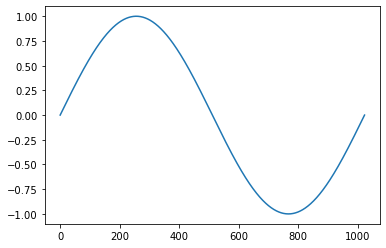

In [555]:
xfield = torch.linspace(0,1,1024)
sinfield = np.sin(2*np.pi*xfield)
tfield = torch.linspace(0,1,50)


plt.plot(sinfield)

sinfield = sinfield.reshape(1,1024,1)
sinfield = sinfield.cuda()

In [1]:
time = []
time.append(sinfield.cpu().detach().numpy())
w = model(sinfield)
time.append(w.cpu().detach().numpy())
for i in range(0,48):
    w = model(w)
    time.append(w.cpu().detach().numpy())
    
timenp = np.array(time)

timenp = timenp[:,-1,:,-1]

NameError: name 'sinfield' is not defined

Text(0, 0.5, 'U')

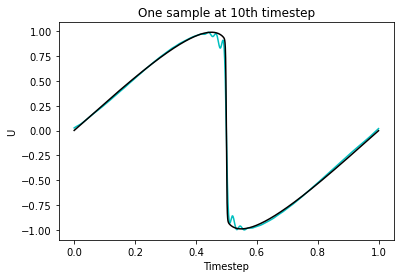

In [557]:
plt.plot(xfield.detach().numpy(), timenp[10,:], 'c')
plt.plot(xfield.detach().numpy(), U[:,10], 'k')

plt.title("One sample at 10th timestep")
plt.xlabel('Timestep')
plt.ylabel('U')

#plt.savefig("Sample_1.png")

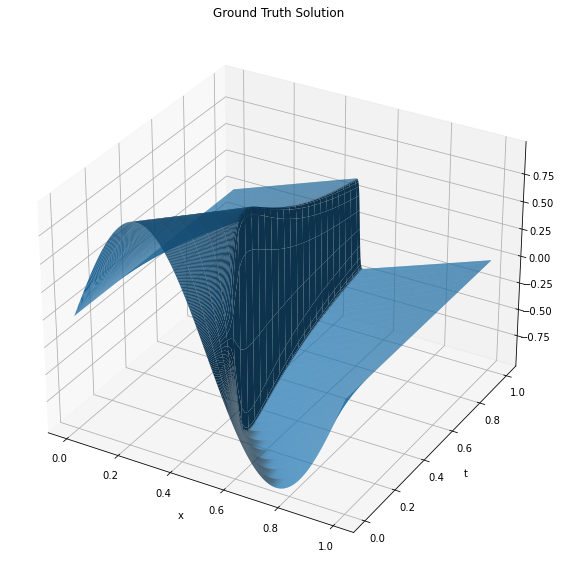

In [596]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(xfield.detach().numpy(),tfield.detach().numpy())

fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,U.T,rstride=2,cstride=2)

plt.title("Ground Truth Solution")
plt.xlabel('x')
plt.ylabel('t')

plt.savefig('Figures/FNO-AG1.png')

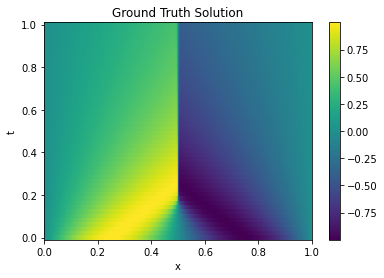

In [600]:
plt.pcolormesh(X,Y,U.T)
plt.colorbar()
plt.title("Ground Truth Solution")
plt.xlabel('x')
plt.ylabel('t')

plt.savefig('Figures/FNO-AG3.png')

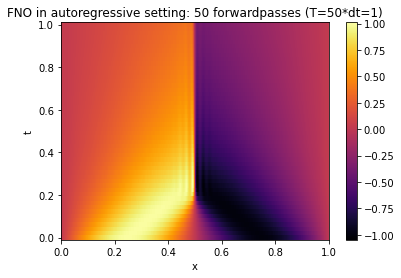

In [601]:
plt.pcolormesh(X,Y,timenp,cmap='inferno')
plt.colorbar()
plt.title("FNO in autoregressive setting: 50 forwardpasses (T=50*dt=1)")
plt.xlabel('x')
plt.ylabel('t')

plt.savefig('Figures/FNO-AG4.png')

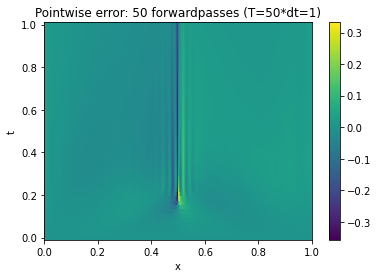

In [602]:
plt.pcolormesh(X,Y,error.T)
plt.colorbar()
plt.title("Pointwise error: 50 forwardpasses (T=50*dt=1)")
plt.xlabel('x')
plt.ylabel('t')

plt.savefig('Figures/FNO-AG5.png')

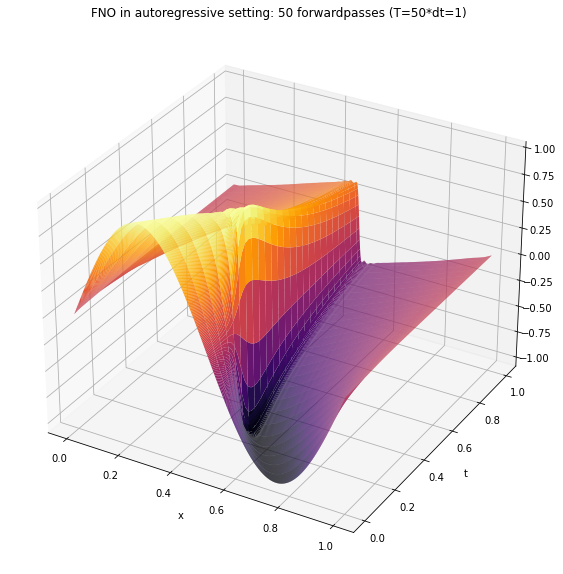

In [598]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,timenp,rstride=2,cstride=2,cmap='inferno')

plt.title("FNO in autoregressive setting: 50 forwardpasses (T=50*dt=1)")
plt.xlabel('x')
plt.ylabel('t')

plt.savefig('Figures/FNO-AG2.png')

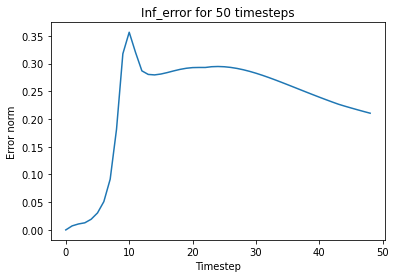

In [603]:
from numpy import linalg as LA

#pointwise error
error = timenp.T - U[:,:] 


#Infinity norm
max_error = []
for i in range(0,49):
    max_error.append(LA.norm(error[:,i], np.inf)) 
    
inf_error = np.array(max_error)

plt.plot(inf_error)
plt.title("Inf_error for 50 timesteps")
plt.xlabel('Timestep')
plt.ylabel('Error norm')

plt.savefig("Figures/Error_3_SimpleSine.png")

# KFR

In [4]:
################################################################
#  configurations
################################################################
ntrain = 435
ntest = 100

#sub = 2**3 #subsampling rate
#h = 2**13 // sub #total grid size divided by the subsampling rate
s = 207

Tin=200
T=200
step = 1

In [5]:
################################################################
# read data
################################################################
x_data = torch.tensor(np.load('data/input_long.npy', allow_pickle=True))[:535,:]
y_data = torch.tensor(np.load('data/u_results_long.npy', allow_pickle=True))[:535,:]


x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

x_train = x_train[:,:,-201:-1]
y_train = y_train[:,:,0:200]
x_test = x_test[:,:,-201:-1]
y_test = y_test[:,:,0:200]

In [286]:
#xx = x_train[318,:,:].reshape(1,207,200).cuda()
xx = x_data_try.cuda() 

start = time.time()
for t in range(0,95085,1):
    #print('it enters')
    #y = yy[..., t:t+step]
    with torch.no_grad():
        out = model(xx)
    #loss += myloss(out.reshape(batch_size, -1), y.reshape(batch_size, -1))
    #print('it reaches')
    if t == 0:
        pred_1 = out
    else:
        pred_1 = torch.cat((pred_1, out), -1)

    xx = torch.cat((xx[..., step:],out),dim=-1)
    
print("total time taken this loop: ", time.time() - start)

total time taken this loop:  232.8393898010254


In [366]:
#xx = x_test[-2,:,:].reshape(1,207,200).cuda()
xx = x_data_try.cuda()

start = time.time()
for t in range(0,40000,1):
    #print('it enters')
    #y = yy[..., t:t+step]
    with torch.no_grad(): 
        out = model(xx)
    #loss += myloss(out.reshape(batch_size, -1), y.reshape(batch_size, -1))
    #print('it reaches')
    if t == 0:
        pred_2 = out
    else:
        pred_2 = torch.cat((pred_2, out), -1)

    xx = torch.cat((xx[..., step:],out),dim=-1)
    
print("total time taken this loop: ", time.time() - start)

total time taken this loop:  86.97276043891907


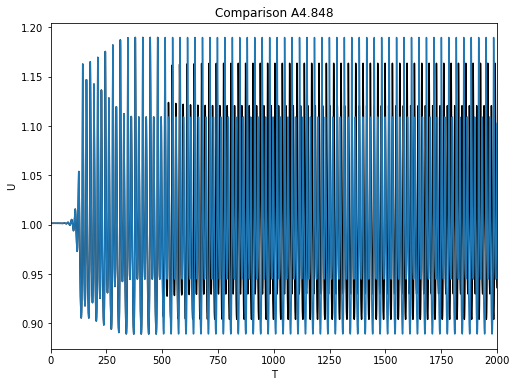

In [551]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6))

plt.plot(t_extended, np.append(U_value[:,-1], pred_1[:,-1,:].cpu().detach().numpy()),'k')

plt.plot(t_value2, U_value2[:,-1])


plt.title("Comparison A4.848")
plt.xlabel('T')
plt.ylabel('U')
plt.xlim([0, 2000])


#plt.savefig("Extrapolate3.jpg")


plt.show()

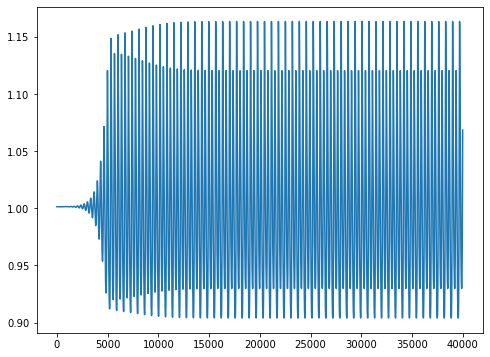

In [368]:
figure(figsize=(8, 6))

plt.plot(pred_2[:,-1,:][-1].cpu().detach().numpy())

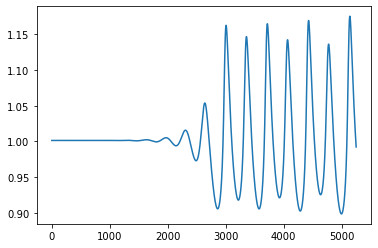

In [248]:
plt.plot(U_value1[:,-1])

In [290]:
U_value2.shape

(105618, 207)

In [234]:
U_exp.shape

(10533,)

# Error

In [292]:
U_exp = np.append(U_value[:,-1], pred_1[:,-1,:].cpu().detach().numpy())

In [293]:
#pointwise error
error_time = [U_value2[:,-1] - U_exp]

In [323]:
error_time_div = [U_value2[:,-1] - U_exp]/U_value2[:,-1]

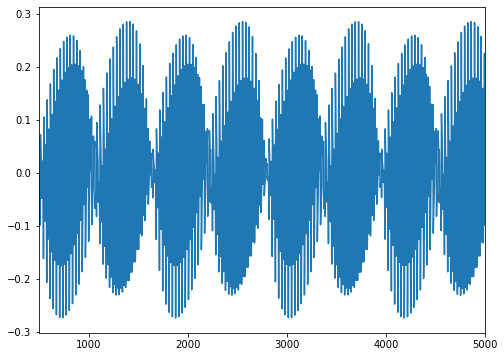

In [327]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6))

plt.plot(t_value2, error_time[:].T)

plt.xlim([495, 5000])


plt.savefig("Error.jpg")

In [272]:
from numpy import linalg as LA

max_error = []
for i in range(0,100367):
    max_error.append(LA.norm(error_time, 2))
    
inf_error = np.array(max_error)


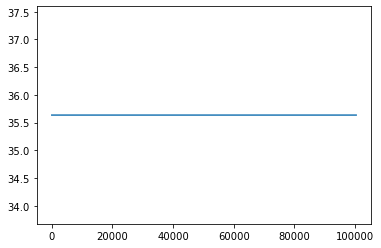

In [273]:
plt.plot(inf_error)

# Alpha = 4.848

In [176]:
U = np.load('amp_0alpha_4.848.npz')

In [177]:
U_value = U['u']
t_value = U['t']

In [194]:
U_250 = np.load('amp_0alpha_4.848.npz')

In [195]:
U_value1 = U_250['u']
t_value1 = U_250['t']

In [249]:
U_5000 = np.load('amp_0alpha_4.848.npz')

In [250]:
U_value2 = U_5000['u']
t_value2 = U_5000['t']

In [370]:
DictA4848 = {"U_250": U_value1, "u_5000": U_value2, "u_500": U_value, "dt": dt}

np.save("Alpha4848",DictA4848)

In [285]:
t_value.shape

(10533,)

In [369]:
dt = (t_value[1]-t_value[0])
dt

0.04787225223000799

In [288]:
t_extended = t_value
for i in range(1,95086):
    t_extended = np.append(t_extended,t_extended[-1]+dt)

In [349]:
x_data_try = ((torch.from_numpy(U_value1.T)).reshape(1,207,-1))[:,:,0:200].float()

In [346]:
x_data_try.shape

torch.Size([1, 207, 200])

# Alpha = 4.637

In [538]:
U44 = np.load('amp_0alpha_4.82.npz')

In [549]:
U_value44 = U44['u']
t_value44 = U44['t']

x_data_try44 = ((torch.from_numpy(U_value44.T)).reshape(1,207,-1))[:,:,8600:8800].float()

In [550]:
#xx = x_test[-23,:,:].reshape(1,207,200).cuda()
xx = x_data_try44.cuda() 

start = time.time()
for t in range(0,10000,1):
    #print('it enters')
    #y = yy[..., t:t+step]
    with torch.no_grad():
        out = model(xx)
    #loss += myloss(out.reshape(batch_size, -1), y.reshape(batch_size, -1))
    #print('it reaches')
    if t == 0:
        pred_44 = out
    else:
        pred_44 = torch.cat((pred_44, out), -1)

    xx = torch.cat((xx[..., step:],out),dim=-1)
    
print("total time taken this loop: ", time.time() - start)

total time taken this loop:  21.660964965820312


# True Solution Examples

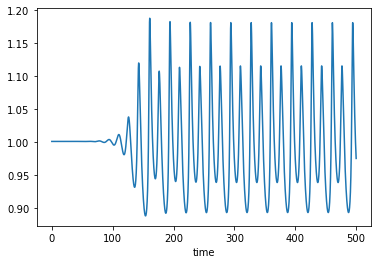

In [540]:
plt.plot(t_value44, U_value44[:,-1])
plt.xlabel('time')

plt.show()

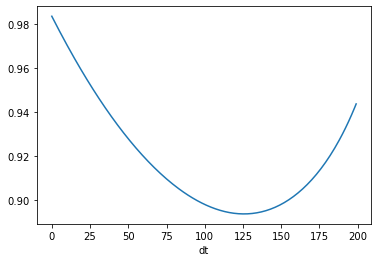

In [544]:
plt.plot(U_value44[-401:-201,-1])
plt.xlabel('dt')

plt.show()

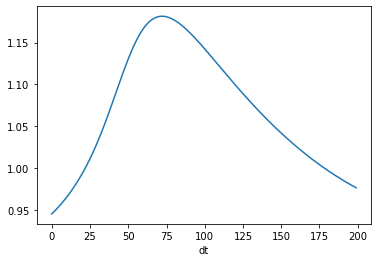

In [545]:
plt.plot(U_value44[-201:-1,-1])
plt.xlabel('dt')

plt.show()

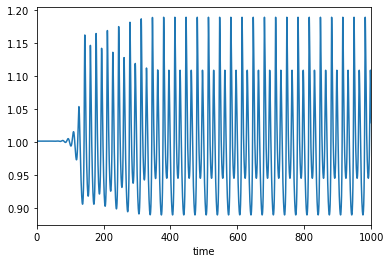

In [516]:
plt.plot(t_value2, U_value2[:,-1])


plt.xlim([0,1000])
plt.xlabel('time')

plt.show()

# Experimental Solution Examples

(0.0, 10000.0)

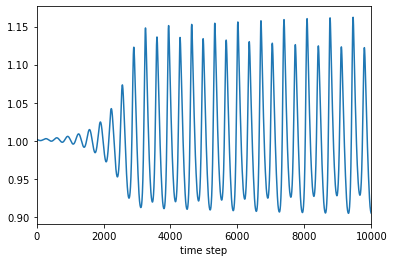

In [533]:
plt.plot(np.append(x_test[-11,-1,:], pred_45[:,-1,:][-1].cpu().detach().numpy()))
plt.xlabel('time step')

plt.xlim([0,10000])

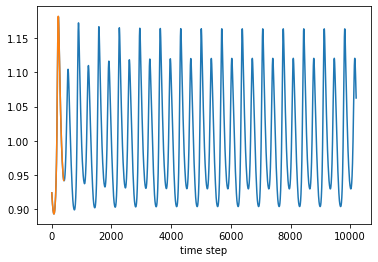

In [543]:
#plt.plot(U_value44[8600:9000,-1])

plt.plot(np.append(x_test[-23,-1,:], pred_44[:,-1,:][-1].cpu().detach().numpy()))

plt.plot(np.append(x_test[-23,-1,:], y_test[-23,-1,:]))


#plt.xlim([0,10000])
plt.xlabel('time step')

plt.show()

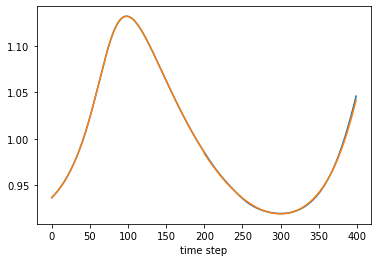

In [521]:
plt.plot(np.append(x_test[-10,-1,:], pred_44[:,-1,:][-1].cpu().detach().numpy()))

plt.plot(np.append(x_test[-10,-1,:], y_test[-10,-1,:]))

plt.xlabel('time step')
plt.show()

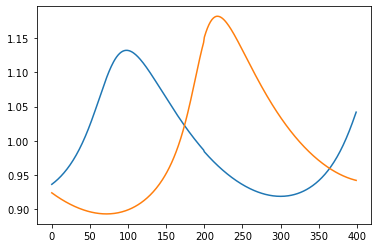

In [524]:
plt.plot(np.append(x_test[-10,-1,:], y_test[-10,-1,:]))
#plt.plot(np.append(x_test[-11,-1,:], y_test[-11,-1,:]))
plt.plot(np.append(x_test[-23,-1,:], y_test[-23,-1,:]))

plt.show()

In [6]:
from typing import Optional

def generate_params() -> (int, np.ndarray, np.ndarray, np.ndarray):
    """
    Returns parameters for initial conditions.
    Args:
        None
    Returns:
        int: number of Fourier series terms
        np.ndarray: amplitude of different sine waves
        np.ndarray: phase shift of different sine waves
        np.ndarray: frequency of different sine waves
    """
    N = 10
    lmin, lmax = 1, 3
    A = (np.random.rand(1, N) - 0.5)
    phi = 2.0*np.pi*np.random.rand(1, N)
    l = np.random.randint(lmin, lmax, (1, N))
    return (N, A, phi, l)

def initial_conditions(x: np.ndarray, 
                       L: int, 
                       nu: float, 
                       scale: float= 10, 
                       params: Optional[list]=None) -> np.ndarray:
    """
    Return initial conditions based on initial parameters.
    Args:
        x (np.ndarray): input array of spatial grid
        L (float): length of the spatial domain
        nu (float): viscosity parameter
        scale (float): scale parameter for inverse Cole-Hopf transformation
        params (Optinal[list]): input parameters for generating initial conditions
    Returns:
        np.ndarray: initial condition
    """
    if params is None:
        params = generate_params()
    N, A, phi, l = params
    # Burgers' equation solution
    psi0 = np.sum(A * np.sin((2 * np.pi * l * x[:, None] / L ) + phi), -1)
    return psi0

In [7]:
nu = 0.01
L = 2 * np.pi
N = 2**8
x = np.linspace(0, (1-1.0/N)*L, N)
T = 2**4
t = np.linspace(0, T, N)

In [19]:
psi0 = initial_conditions(x, L, nu, scale=10)

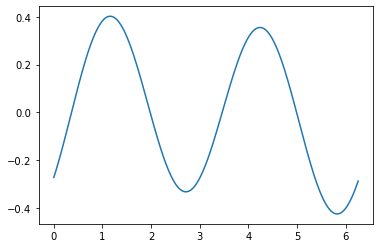

In [20]:
plt.plot(x,psi0)

In [36]:
start = -5000
for i in range(0,1500):
    start += 3
print(start)

-500


In [42]:
((0.064*10000)+1.28)/((2.45e-3*10000)+421)

1.4394612794612793